In [80]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import math
import seaborn as sns

filepath = 'data/heart.csv'
df = pd.read_csv(filepath)

# Introduction
This project explores the machine learning pipeline by working on [Heart Failure Data](https://www.kaggle.com/fedesoriano/heart-failure-prediction), found on Kaggle. The target variable we classify is HeartDisease, a binary datatype where 1 indicates the person has Heart Disease, and 0 (normal) otherwise. Heart disease is the leading cause of death in the world, and machine learning models that can predict which persons are at a high risk for heart disease early can help spur action to increase the likelihood of positive health outcomes for those users, in addition to encouraging persons who might not be at risk currently to make cautionary lifestyle changes. This dataset comprises 918 persons, recording 12 observations each. This datset is already described as follows (the annotation (CTS) means that attribute is continuous, while (CAT) indicates the attribute is categorical, and (ORD) indicates ordinal attribute):

Age: age of the patient (years) (CTS)

Sex: sex of the patient (M: Male, F: Female) (CAT)

ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic) (ORD)

RestingBP: resting blood pressure (mm Hg) (CTS)

Cholesterol: serum cholesterol (mm/dl) (CTS)

FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise) (ORD)

RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria) (CAT)

MaxHR: maximum heart rate achieved (Numeric value between 60 and 202) (CTS)

ExerciseAngina: exercise-induced angina (Y: Yes, N: No) (CAT)

Oldpeak: oldpeak = ST (Numeric value measured in depression) (CTS)

ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping) (ORD)

HeartDisease: output class (1: heart disease, 0: Normal) 


Looking at the various public project submissions on Kaggle, we see all of them attempt to solve the same sort of classification problem. The two models I saw most frequently were RandomForestClassifiers and Logistic Regression (sometimes w/ PCA), and all of the public projects seemed to achieve accuracy scores of at least 80%.

## Exploratory Data Analysis

In [82]:
#we eliminate abbreviations to make EDA smooth
df['ChestPainType'] = df.ChestPainType.replace({'ASY': 'Asymptomatic',
                                             'ATA': 'Atypical Angina',
                                             'NAP': 'Non-Anginal Pain',
                                              'TA': 'Typical Angina'})
df['ChestPainType'].unique()

array(['Atypical Angina', 'Non-Anginal Pain', 'Asymptomatic',
       'Typical Angina'], dtype=object)

In [75]:
print("Rows: "+ str(df.shape[0]))
print("Columns: "+ str(df.shape[1]))
cols = list(df.columns)
for col in cols:
    df1 = df[col].dropna()
    #print(df1.describe())
    print(f"dtype of {col} is: {df1.dtype}")

Rows: 918
Columns: 12
dtype of Age is: int64
dtype of Sex is: object
dtype of ChestPainType is: object
dtype of RestingBP is: int64
dtype of Cholesterol is: int64
dtype of FastingBS is: int64
dtype of RestingECG is: object
dtype of MaxHR is: int64
dtype of ExerciseAngina is: object
dtype of Oldpeak is: float64
dtype of ST_Slope is: object
dtype of HeartDisease is: int64


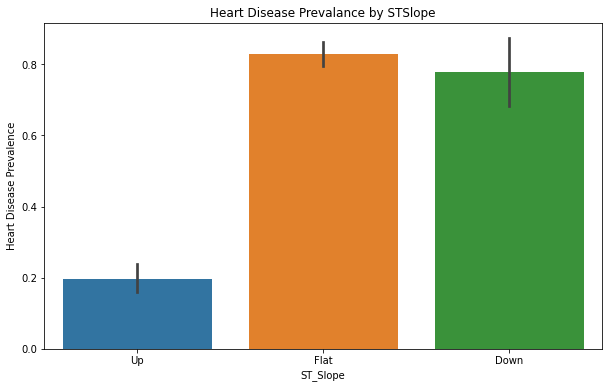

In [91]:
fig=plt.figure(figsize=(10,6))
sns.barplot(y='HeartDisease',x='ST_Slope',data=df)
plt.title("Heart Disease Prevalance by STSlope")
plt.ylabel("Heart Disease Prevalence")
plt.savefig("figures/HeartDisease_grpStSlope.png")


Caption: We see Heart Disease patients in general experience more depressed peak slopes

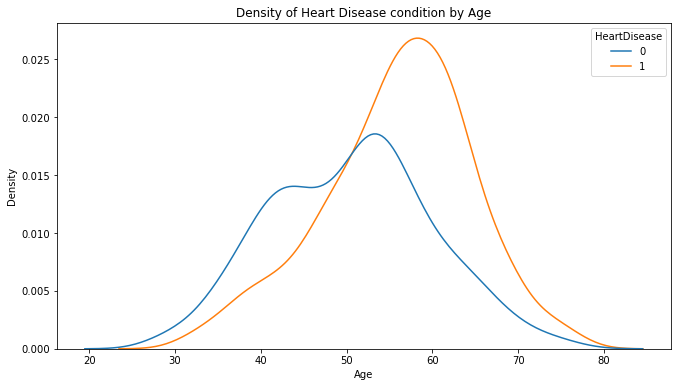

In [77]:
fig=plt.figure(figsize=(11,6))
sns.kdeplot(df['Age'],hue = df['HeartDisease'])
plt.title("Density of Heart Disease condition by Age")
plt.savefig("figures/Age_HD_kde.png")

Caption: The distribution of Heart Disease patients centers around individuals in their upper 50s, while Normal patients are younger, and have more variance.

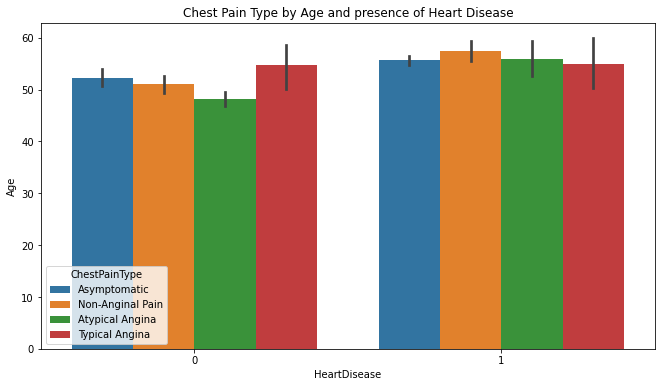

In [86]:
fig = plt.figure(figsize=(11,6))
sns.barplot(x="HeartDisease",y="Age", hue="ChestPainType", 
            hue_order=['Asymptomatic','Non-Anginal Pain','Atypical Angina','Typical Angina'] ,data=df)

plt.title("Chest Pain Type by Age and presence of Heart Disease")
plt.savefig("figures/ChestPainHue_Disease_Age.png")

Caption: Chest pain type in conjunction with age is not a relevant indicator for Heart Disease, as there is no immediate correlation between severity of pain and age, nor severity of pain and heart disease status.

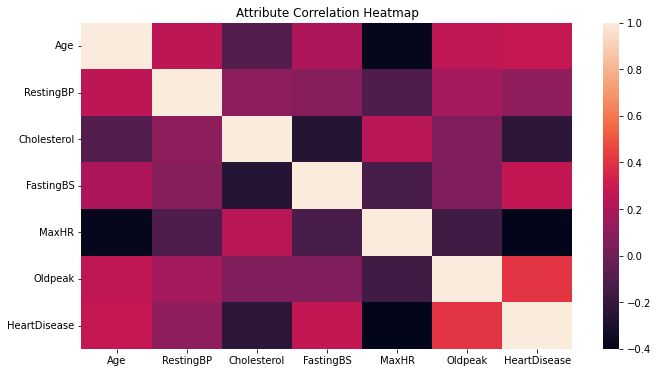

In [59]:
fig = plt.figure(figsize=(11,6))
sns.heatmap(df.corr())
plt.title("Attribute Correlation Heatmap")
plt.savefig("figures/AttributeCorrHeatmap.png")

Caption: Not much correlation besides Oldpeak and HeartDisease

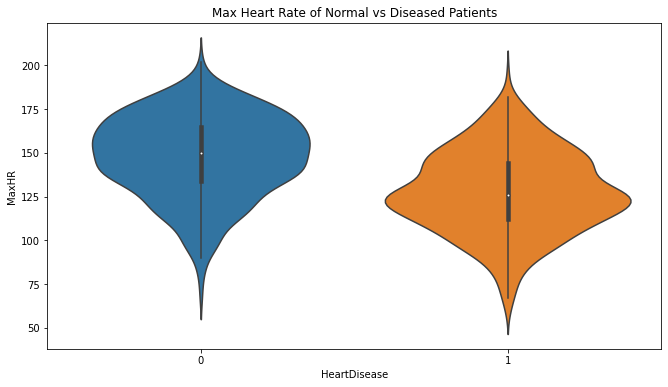

In [90]:
fig = plt.figure(figsize=(11,6))
sns.violinplot(x="HeartDisease",y="MaxHR", data=df)
plt.title("Max Heart Rate of Normal vs Diseased Patients")
plt.savefig("figures/HR_HD_violin.png")

## Preprocessing
We split the dataset according to the following assumptions: There is no group structure, the data is IID, and the data is not time-series. We aim to split the dataset into 20% testing, and 80% other. The other set will be split into 25% for validation, and 75% for training.

We apply each encoder to some of the attributes as follows:

OrdinalEncoder - ST_Slope, ChestPainType
MinMaxEncoder - Age, RestingBP, Cholesterol, MaxHR, Oldpeak
OneHotEncoder - Sex, ExerciseAngina, RestingECG, FastingBS

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from math import isclose


def basic_split(X, y, train_size, val_size, test_size, random_seed):
    #test inputs, break function if inputs violate the tests.
    if not type(random_seed) is int:
        raise ValueError("random_seed must be an integer")
    if not train_size+val_size+test_size == 1:
        raise ValueError("ratios of testing, training, and validation data must be non-negative and adds to 1")
    if train_size < 0 or val_size < 0 or test_size < 0:
        raise ValueError("ratios for test,train,and validation must be non-negative")
    
    #now that inputs are gucci, use sklearn to create the split
    diff = 0
    X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = test_size, random_state=random_seed)
    #X_other is of relative size (1-test), so to get the splitting as desired, the validation set must be scaled by (1/1-test)
    tvS = val_size/(1-test_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_other, Y_other, test_size = tvS, random_state=random_seed)
    
    #test outputs, break function if outputs are not the desired size
    xrows = X.shape[0]
    yrows = y.shape[0]
    if not isclose(X_test.shape[0], xrows*test_size, abs_tol=2):
        raise ValueError("test set is not of expected size")
    if not isclose(X_train.shape[0], xrows*train_size, abs_tol=2):
        raise ValueError("train set is not of expected size",)
    if not isclose(X_val.shape[0], xrows*val_size, abs_tol=2):
        raise ValueError("validation set is not of expected size")
    if not isclose(Y_train.shape[0], yrows*train_size, abs_tol=2):
        raise ValueError("train target set is not of expected size")
    if not isclose(Y_test.shape[0], yrows*test_size, abs_tol=2):
        raise ValueError("test target set is not of expected size")
    if not isclose(Y_val.shape[0], yrows*val_size, abs_tol=2):
        raise ValueError("validation target set is not of expected size")
        
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

feature = df.drop(columns="HeartDisease")
target = df["HeartDisease"]

random_seed = 42
x_tr, y_tr, x_v, y_v, x_te, y_te = basic_split(feature, target, .6,.2,.2,random_seed)
print(x_tr.head())
print(x_v.head())
print(x_te.head())

     Age Sex     ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
364   56   M  Non-Anginal Pain        120            0          0     Normal   
98    56   M      Asymptomatic        120           85          0     Normal   
600   57   M      Asymptomatic        130          207          0         ST   
201   46   M  Non-Anginal Pain        120          230          0     Normal   
345   69   M      Asymptomatic        135            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  
364     97              N      0.0     Flat  
98     140              N      0.0       Up  
600     96              Y      1.0     Flat  
201    150              N      0.0       Up  
345    130              N      0.0     Flat  
     Age Sex     ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
540   62   M  Non-Anginal Pain        138          204          0         ST   
783   45   F      Asymptomatic        138          236          0        LVH   
277

In [71]:
ordinal = ['ST_Slope','ChestPainType']
minmax = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
onehot = ['Sex','ExerciseAngina','RestingECG','FastingBS']

preprcessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot),
                  ('minmax', MinMaxScaler(), minmax),
                  ('ordinal',OrdinalEncoder(), ordinal)])

ppl = Pipeline(steps=[('prerocessor',preprcessor)])


X_train_pre = ppl.fit_transform(x_tr)
X_val_pre = ppl.fit(x_v)
X_test_pre = ppl.fit(x_te)
print(x_tr.shape)
print(X_train_pre.shape)

(550, 11)
(550, 16)


array([0.        , 1.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.5625    ,
       0.6       , 0.        , 0.26056338, 0.26315789, 1.        ,
       2.        ])

### References
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved 6 October 2021 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

### Github
https://github.com/makhas/midterm-1030